# Prerequirements

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"snv023","key":"ad4d7b85084a586f713a6247465b4b67"}'}

In [0]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list --mine

-rw-r--r-- 1 root root 62 May 12 13:46 kaggle.json
ref                      title             size  lastUpdated          downloadCount  
-----------------------  ----------------  ----  -------------------  -------------  
snv023/facial-keypoints  facial_keypoints  13GB  2020-04-22 20:42:48             15  


In [0]:
!kaggle datasets download -d snv023/facial-keypoints

100% 12.6G/12.6G [05:14<00:00, 32.8MB/s]
100% 12.6G/12.6G [05:14<00:00, 43.0MB/s]


In [0]:
!unzip -q *.zip
!rm *.zip

In [0]:
import numpy as np 
import pandas as pd
import os

import cv2
import pickle
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import tqdm
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from albumentations import (Blur, MotionBlur, RandomBrightnessContrast, 
                            Compose, OneOf)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [0]:
np.random.seed(2023)
torch.manual_seed(2023)

TRAIN_SIZE = 0.8
NUM_PTS = 971
CROP_SIZE = 128
PATH_TO_DATA = 'data-2'
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 35
NAME = 'resnet50'

SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"

# For dataloader

In [0]:
class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        self.size = torch.tensor(size, dtype=torch.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample["crop_margin_x"] = margin_w
        sample["crop_margin_y"] = margin_h

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2)
            landmarks -= torch.tensor((margin_w, margin_h), dtype=landmarks.dtype)[None, :]
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample

In [0]:
def aug(p=0.6):
    return OneOf([
            MotionBlur(blur_limit=5, p=0.3),
            RandomBrightnessContrast(p=0.3)
    ], p=p)


class AlbumentationAugmenter(object):
    def __init__(self, elem_name='image'):
        self.elem_name = elem_name
        self.aug = aug(p=0.7)
    
    def __call__(self, sample):
        img = np.array(sample['image'])
        image = self.aug(image=img)['image']
        sample['image'] = torch.tensor(image)
        
        return sample

In [0]:
class ThousandLandmarksDataset(data.Dataset):
    def __init__(self, root, transforms, split="train"):
        super(ThousandLandmarksDataset, self).__init__()
        self.root = root
        landmark_file_name = os.path.join(root, 'landmarks.csv') if split is not "test" \
            else os.path.join(root, "test_points.csv")
        images_root = os.path.join(root, "images")

        self.image_names = []
        self.landmarks = []

        with open(landmark_file_name, "rt") as fp:
            num_lines = sum(1 for line in fp)
        num_lines -= 1  # header

        with open(landmark_file_name, "rt") as fp:
            for i, line in tqdm.tqdm(enumerate(fp)):
                if i == 0:
                    continue  # skip header
                if split == "train" and i == int(TRAIN_SIZE * num_lines):
                    break  # reached end of train part of data
                elif split == "val" and i < int(TRAIN_SIZE * num_lines):
                    continue  # has not reached start of val part of data
                elements = line.strip().split("\t")
                image_name = os.path.join(images_root, elements[0])
                self.image_names.append(image_name)

                if split in ("train", "val"):
                    landmarks = list(map(np.int16, elements[1:]))
                    landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))
                    self.landmarks.append(landmarks)

        if split in ("train", "val"):
            self.landmarks = torch.as_tensor(self.landmarks)
        else:
            self.landmarks = None

        self.transforms = transforms

    def __getitem__(self, idx):
        sample = {}
        if self.landmarks is not None:
            landmarks = self.landmarks[idx]
            sample["landmarks"] = landmarks

        image = cv2.imread(self.image_names[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        return len(self.image_names)

# Training

In [0]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
train_transforms = transforms.Compose([
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
                        ("image",)),
    ])

In [53]:
train_dataset = ThousandLandmarksDataset(os.path.join(PATH_TO_DATA, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True,
                                       shuffle=True, drop_last=True)
val_dataset = ThousandLandmarksDataset(os.path.join(PATH_TO_DATA, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True,
                                     shuffle=False, drop_last=False)

Streaming output truncated to the last 5000 lines.






352382it [00:57, 655.17it/s]







352450it [00:58, 661.98it/s]







352518it [00:58, 666.56it/s]







352586it [00:58, 669.86it/s]







352654it [00:58, 655.89it/s]







352720it [00:58, 653.55it/s]







352787it [00:58, 657.30it/s]







352853it [00:58, 651.26it/s]







352921it [00:58, 657.72it/s]







352987it [00:58, 655.21it/s]







353053it [00:58, 647.10it/s]







353121it [00:59, 654.62it/s]







353187it [00:59, 656.09it/s]







353253it [00:59, 655.47it/s]







353319it [00:59, 650.75it/s]







353386it [00:59, 656.12it/s]







353452it [00:59, 653.21it/s]







353518it [00:59, 654.48it/s]







353585it [00:59, 657.90it/s]







353653it [00:59, 663.83it/s]







353721it [00:59, 666.24it/s]







353788it [01:00, 659.90it/s]







353855it [01:00, 656.52it/s]







353921it [01:00, 656.51it/s]







353987it [01:00, 623.43it/s]







354052it [01:00, 630.97it/s]







354117i

In [0]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR, amsgrad=True, weight_decay=4e-3)
lr_sheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.25)
loss_fn = F.mse_loss

In [0]:
def train(model, loader, loss_fn, optimizer, device, first_epoch=False):
    model.train()
    train_loss = []
    ploting_loss = []
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="training...")):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 50 == 0:
            clear_output(True)
            ploting_loss.append(np.mean(train_loss[int(i / 50): int(i / 50) + 50]))
            plt.plot(ploting_loss,label='loss_per_50_iterations')
            plt.legend()
            plt.show()
    if first_epoch:
        return np.mean(train_loss[300:])

    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="validation...")):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

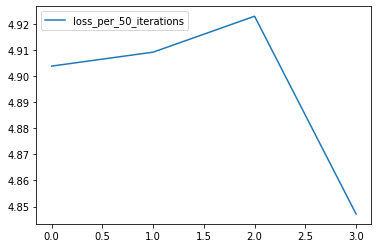









training...:   8%|▊         | 200/2462 [00:58<12:47,  2.95it/s]







training...:   8%|▊         | 201/2462 [00:59<12:06,  3.11it/s]







training...:   8%|▊         | 202/2462 [00:59<11:37,  3.24it/s]







training...:   8%|▊         | 203/2462 [00:59<11:18,  3.33it/s]







training...:   8%|▊         | 204/2462 [00:59<11:08,  3.38it/s]







training...:   8%|▊         | 205/2462 [01:00<10:58,  3.42it/s]







training...:   8%|▊         | 206/2462 [01:00<10:59,  3.42it/s]







training...:   8%|▊         | 207/2462 [01:00<10:49,  3.47it/s]







training...:   8%|▊         | 208/2462 [01:01<10:49,  3.47it/s]







training...:   8%|▊         | 209/2462 [01:01<10:44,  3.50it/s]







training...:   9%|▊         | 210/2462 [01:01<10:40,  3.51it/s]







training...:   9%|▊         | 211/2462 [01:01<10:43,  3.50it/s]







training...:   9%|▊         | 212/2462 [01:02<10:42,  3.50it/s]







training...:   9%|▊         | 213/2462 [01:02<10:39,  3.52it/s]







KeyboardInterrupt: ignored

In [57]:
best_val_loss = np.inf
score_per_epoch = {}
for epoch in range(EPOCHS):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device, first_epoch=(epoch==0))
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    lr_sheduler.step(val_loss)
    print("Epoch #{:2}:\ttrain loss: {:5.4}\tval loss: {:5.4}".format(epoch, train_loss, val_loss))
    score_per_epoch[epoch] = [train_loss, val_loss]
    with open(f"{NAME}_epoch{epoch+1}_tr_loss{round(train_loss, 3)}_val_loss{round(val_loss, 3)}.pth", "wb") as cur_m:
        torch.save(model.state_dict(), cur_m)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(f"{NAME}_best_2.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)

In [0]:
with open("resnet50_best_2.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)
    model.to(device)

# Testing

In [0]:
def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks


def restore_landmarks_batch(landmarks, fs, margins_x, margins_y):
    landmarks[:, :, 0] += margins_x[:, None]
    landmarks[:, :, 1] += margins_y[:, None]
    landmarks /= fs[:, None, None]
    return landmarks

def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [60]:
test_dataset = ThousandLandmarksDataset(os.path.join(PATH_TO_DATA, 'test'), transform['valid'], split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True,
                                      shuffle=False, drop_last=False)










0it [00:00, ?it/s]








41327it [00:00, 413268.42it/s]








99820it [00:00, 408241.98it/s]


In [61]:
test_predictions = predict(model, test_dataloader, device)










test prediction...:   0%|          | 0/780 [00:00<?, ?it/s]








test prediction...:   0%|          | 1/780 [00:03<51:42,  3.98s/it]








test prediction...:   0%|          | 2/780 [00:04<36:35,  2.82s/it]








test prediction...:   1%|          | 4/780 [00:04<25:53,  2.00s/it]








test prediction...:   1%|          | 5/780 [00:05<21:08,  1.64s/it]








test prediction...:   1%|          | 6/780 [00:05<15:20,  1.19s/it]








test prediction...:   1%|          | 8/780 [00:05<11:03,  1.16it/s]








test prediction...:   1%|          | 9/780 [00:06<10:33,  1.22it/s]








test prediction...:   1%|▏         | 11/780 [00:06<07:56,  1.61it/s]








test prediction...:   2%|▏         | 13/780 [00:07<06:57,  1.84it/s]








test prediction...:   2%|▏         | 15/780 [00:07<05:26,  2.35it/s]








test prediction...:   2%|▏         | 17/780 [00:08<05:06,  2.49it/s]








test prediction...:   2%|▏         | 18/780 [00:08<04:07,  3.08it/s]








test p

# Visualize predictions

In [0]:
NUM_IMAGES_TO_SHOW = 25
NUM_COLS = 5
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [0]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [0]:
def draw_landmarks_2(image, landmarks_eval, landmarks_real):
    for point in landmarks_eval:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    for point in landmarks_real:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (0, 128, 192), 1, -1)
    return image

In [65]:
image_names = test_dataset.image_names
landmarks = test_predictions

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


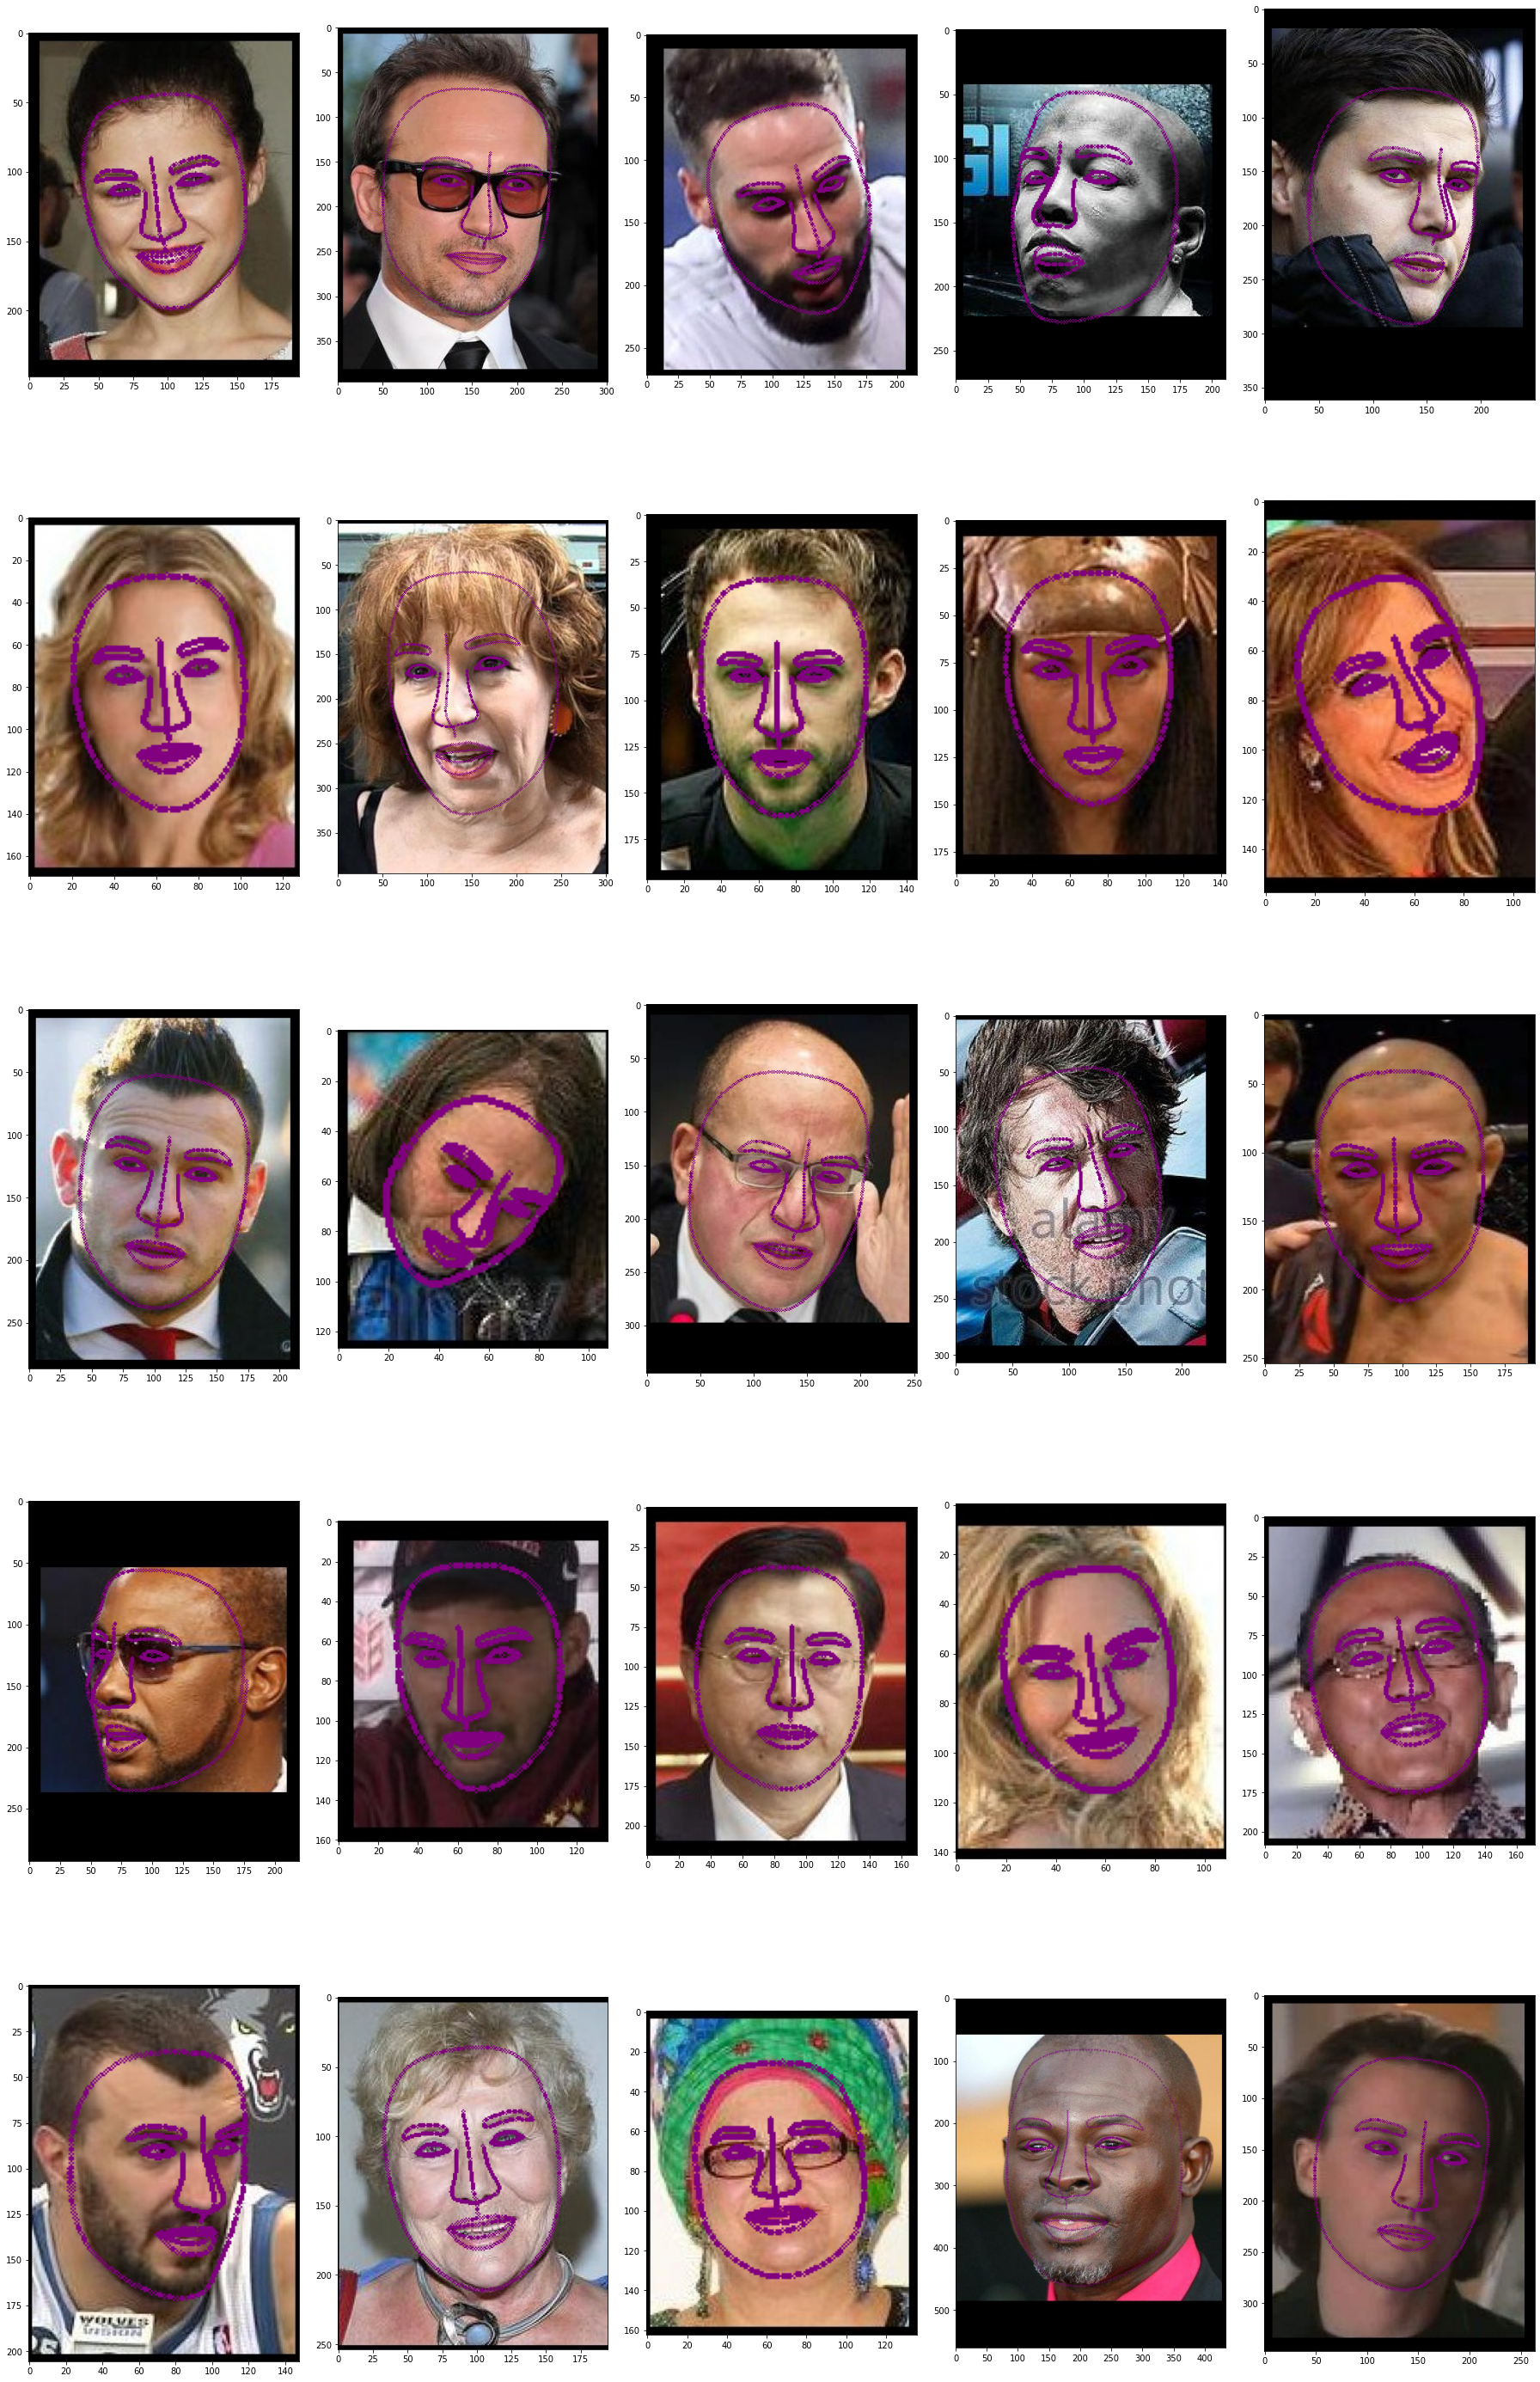

In [66]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()

# Create submissions

In [0]:
def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data, "test")

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter='\t')

    for i, row in mapping.iterrows():
        file_name = row[0]
        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.float).clip(0, 500)
        needed_points = np.around(needed_points)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [0]:
create_submission(PATH_TO_DATA, test_predictions, f"{NAME}_best.csv")